In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import corner
import astropy as ap
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy.visualization import astropy_mpl_style
import pandas as pd
import math
import statistics
import scipy.ndimage as ndimage
import lenstronomy.Util.kernel_util as kernel_util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.Util import util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Util import mask_util
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from memory_profiler import memory_usage
from lenstronomy.Plots.lens_plot import lens_model_plot
from lenstronomy.LensModel.lens_model import LensModel
import random
plt.style.use(astropy_mpl_style)
%matplotlib inline

/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_76569/933700970.py:44: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(img1, ax=ax[0])
/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_76569/933700970.py:49: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(img2, ax=ax[1])
/var/folders/6n/b2_b03_d65dc17frrw6ryn640000gn/T/ipykernel_76569/933700970.py:54: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(img3, ax=ax[2])


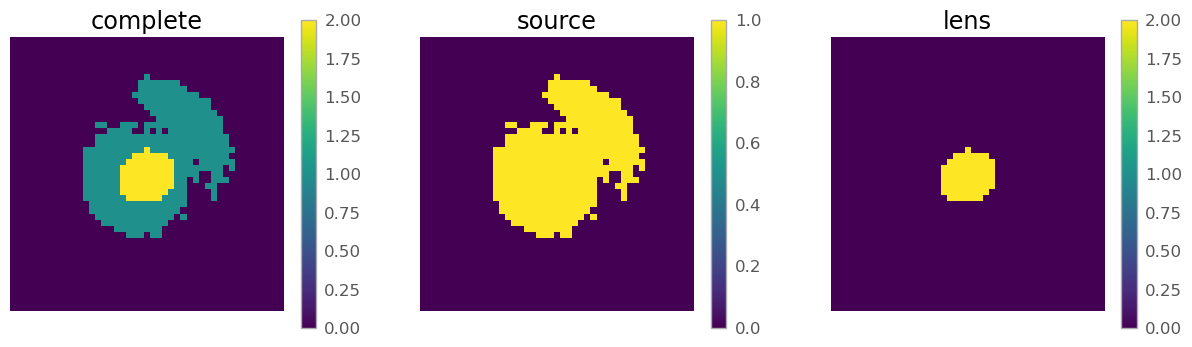

,Y6_COADD_OBJECT_ID,TILENAME,HPIX_16384,HPIX_4096,DNF_ZMEAN_SOF,RA,DEC,FLUX_RADIUS_G,FLUX_RADIUS_R,FLUX_RADIUS_I,...,SKYBRITE_WMEAN_R,SKYBRITE_WMEAN_I,SKYBRITE_WMEAN_Z,Z1,LENSED_MAG,mag_1,ISOLATION,EINSTEIN_RADIUS,MAGNIFICATION,POSITION1
0,966802453,DES2231-0041,1224722390,76545149,0.556774,337.601551,-0.390595,4.940781,4.400977,4.122648,...,1309.380005,3468.550049,6942.839844,1.269530,20.372399,22.029051,0.809375,2.280515,4.598970,3.140025
1,1253235938,DES0213-0541,1158614768,72413423,0.460066,33.705455,-5.731500,4.376857,4.135210,3.885570,...,1266.949951,3035.020020,7321.310059,1.019864,21.060697,22.573709,0.692443,2.308078,4.029071,2.934776
2,1177791444,DES0129+0418,1192223945,74513996,0.564723,22.409156,4.454356,6.379253,5.533293,4.816580,...,1492.119995,3930.610107,8981.299805,1.253888,19.793339,22.035870,0.952243,4.122509,7.888826,5.327848
3,1353299473,DES0257-0124,2415797454,150987340,0.686490,44.207074,-1.514601,4.448493,4.242115,3.715941,...,1194.930054,3673.159912,8193.030273,1.552294,20.011235,22.199661,0.802382,1.883146,7.505342,2.441962
4,1077859177,DES0033-0624,1176538630,73533664,0.251961,8.044105,-6.681857,7.416242,6.677429,6.693459,...,1166.540039,2745.479980,7040.740234,1.384193,19.317760,21.569393,0.759037,3.565714,7.955240,4.517967


In [2]:
filepath = '/Users/gilliancartwright/Desktop/Deep Learning and Image Segmentation/Image-Segmentation/'
filename = filepath + 'labeled_file.fits'

# general functions
def get_data(filename):
    """
    Input: filename
    Output: data table and image array
    """
    hdu_list = fits.open(filename)
    complete_sim = hdu_list[1].data
    source_sim = hdu_list[2].data
    lens_sim = hdu_list[3].data
    complete_mask = hdu_list[4].data
    source_mask = hdu_list[5].data
    lens_mask = hdu_list[6].data
    data = pd.DataFrame(hdu_list[7].data)  # get dataframe data
    hdu_list.close()  # close
    return complete_sim, source_sim, lens_sim, complete_mask, source_mask, lens_mask, data


def plot_image(image_array):
    """
    Input: image array
    Output: plot of image
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image_array, origin='lower')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    plt.show()
    plt.close()
    

def plot_three(img_1, img_2, img_3, titles):
    """
    @author: Jimena Gonzalez
    @author: Gillian Cartwright
    """
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    img1 = ax[0].imshow(img_1, cmap='viridis')
    plt.colorbar(img1, ax=ax[0])  
    ax[0].set_title(titles[0])
    ax[0].axis('off')

    img2 = ax[1].imshow(img_2, cmap='viridis')
    plt.colorbar(img2, ax=ax[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')

    img3 = ax[2].imshow(img_3, cmap='viridis')
    plt.colorbar(img3, ax=ax[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')

    plt.show()
    plt.close()
    

complete_sim, source_sim, lens_sim, complete_mask, source_mask, lens_mask, data = get_data(filename)

plot_three(complete_mask[0], source_mask[0], lens_mask[0],['complete',
                                                           'source',
                                                           'lens'])

# Data Specifics
EXP_TIME = 90.  #  exposure time 
NUM_PIX = 45  #  cutout pixel size per axis
DELTA_PIX = 0.2637  #  pixel size in arcsec

data.head()


In [3]:
def get_rms(image, complete_mask):
    """
    Input: image and region of background
    Output: rms_list (g,r,i)
    """
    # get coordinates of the background region from mask
    background_coords = []
    for i in range(NUM_PIX):
        for j in range(NUM_PIX):
            if complete_mask[i][j] == 0:
                background_coords.append([i, j])
                
    # randomly select half of the background for sampling
    g_vals = []
    r_vals = []
    i_vals = []
    random.seed(123456789)  # set random seed for replication
    for coords in random.sample(background_coords, int(len(background_coords)/2)):
        g_vals.append(image[0, coords[0], coords[1]])
        r_vals.append(image[1, coords[0], coords[1]])
        i_vals.append(image[2, coords[0], coords[1]])

    rms_list = []  # rms values will be saved here and returned
    for flat_image in [g_vals, r_vals, i_vals]:
        squared_vals = []
        for i in range(len(flat_image)):
            squared_vals.append(flat_image[i]**2)
        rms_list.append(np.sqrt(np.mean(squared_vals)))
    
    

    return rms_list[0], rms_list[1], rms_list[2]


In [4]:
def get_lens_coords(complete_mask):
    # get coordinates of the lens region from mask
    lens_ra = []
    lens_dec = []
    for i in range(NUM_PIX):
        for j in range(NUM_PIX):
            if complete_mask[i][j] == 2:
                ra = (i - (NUM_PIX)/2) * DELTA_PIX
                dec = (j - (NUM_PIX)/2) * DELTA_PIX
                lens_ra.append(ra)
                lens_dec.append(dec)

    return lens_ra, lens_dec

In [5]:
def approx_theta_E(center_ra, center_dec, complete_mask):
    """
    Input: lens position (center_ra, center_dec) in arcsec
           and source mask
    Output: estimated theta_E
    """
    d = []
    for i in range(0, NUM_PIX):
        for j in range (0, NUM_PIX):
            if complete_mask[i][j] == 1:
                # translate x, y into ra, dec
                ra = (i - (NUM_PIX)/2) * DELTA_PIX
                dec = (j - (NUM_PIX)/2) * DELTA_PIX
                
                delta_ra = center_ra - ra
                delta_dec = center_dec - dec

                dist = math.sqrt(delta_ra ** 2 + delta_dec ** 2)
                d.append(dist)

    # theta_E is the average of distances to center
    theta_E = statistics.mean(d)
    print(f"'Estimated theta_E': {round(theta_E, 2)}")
    return theta_E

In [6]:
def add_mask(band, kwargs_data, kwargs_psf, kwargs_numerics):
    """ 
    Input: band (g,r,i), corresponding kwargs_data and kwargs_psf for band
    Output: updated kwargs_data for the band with mask applied
    """
    # apply mask
    imageData = ImageData(**kwargs_data)
    imagePSF = PSF(**kwargs_psf)
    imageFit = ImageLinearFit(data_class=imageData, 
                          psf_class=imagePSF,
                          kwargs_numerics=kwargs_numerics, 
                          likelihood_mask=mask_2d)

    mask_1d = imageFit.image2array_masked(band)
    masked_image = imageFit.array_masked2image(mask_1d)

#     # plots the image with mask for reference 
#     plt.figure()
#     plt.imshow(masked_image, origin='lower', cmap='gray', alpha=0.5)
#     plt.show()
#     plt.close()

    # update kwargs_data with masked image
    kwargs_data.update({'image_data': masked_image})

In [7]:
def get_stats(values):
    return np.mean(values), np.std(values), np.min(values), np.max(values)

In [8]:
def model_plot_all_bands(modelPlot, coadd_id):
    f, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes[0][0].set_title('I-Band')
    axes[0][1].set_title('R-Band')
    axes[0][2].set_title('G-Band')
    
    # plot observed, reconstructed, residual, and magnification plots
    for i in range(3):
        modelPlot.data_plot(ax=axes[i][0], band_index=i)
        modelPlot.model_plot(ax=axes[i][1], image_names=True, band_index=i)
        modelPlot.normalized_residual_plot(ax=axes[i][2], v_min=-6, v_max=6, band_index=i)
        modelPlot.magnification_plot(ax=axes[i][3], band_index=i)

    plt.savefig(str(coadd_id)+'_model.png', format='png')
    plt.show()


In [38]:
def model(coadd_id):
    """
    ============================================================================
    Input:
    * COADD_OBJECT_ID to index FITS file
    ============================================================================
    Output: void
        * corner plot: TODO: image
        * parameter trace plots TODO: image
        * parameter results and reduced chi^2 TODO: .txt
        * model plots TODO: image
            * observed
            * reconstructed
            * residuals
            * magnification model
    ============================================================================
    """
    # Data from image
    image, _, _, complete_mask, _, _, data = get_data(filename)
    row = data[data['Y6_COADD_OBJECT_ID'] == coadd_id].index[0]
    
    # image data
    g = image[row, 0, :, :]
    r = image[row, 1, :, :]
    i = image[row, 2, :, :]
    
    # fwhm from data table
    fwhm_g = data.loc[row, 'FWHM_WMEAN_G']
    fwhm_r = data.loc[row, 'FWHM_WMEAN_R']
    fwhm_i = data.loc[row, 'FWHM_WMEAN_I']
    
    # background
    rms_g, rms_r, rms_i = get_rms(image[row], complete_mask[row])
    
    # lens
    lens_ra, lens_dec = get_lens_coords(complete_mask[row])
    center_ra, delta_ra, min_ra, max_ra = get_stats(lens_ra)
    center_dec, delta_dec, min_dec, max_dec = get_stats(lens_dec)

    # source
    theta_E = approx_theta_E(center_ra, center_dec, complete_mask[row])
    
    # set models to use
    lens_model_list = ['SIE']
    source_model_list = ['SERSIC_ELLIPSE']
    lens_light_model_list = ['SERSIC_ELLIPSE']
    
    # generate the coordinate grid and image properties
    _, _, RA_0, DEC_0, _, _, M_PIX2COORD, _ = util.make_grid_with_coordtransform(numPix=NUM_PIX,
                                                                                 deltapix=DELTA_PIX,
                                                                                 center_ra=0,
                                                                                 center_dec=0,
                                                                                 subgrid_res=1,
                                                                                 inverse=False)

    # generate the psf variables for each band
    kwargs_psf_g = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_g, 'pixel_size': DELTA_PIX, 'truncation': 3}
    kwargs_psf_r = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_r, 'pixel_size': DELTA_PIX, 'truncation': 3}
    kwargs_psf_i = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm_i, 'pixel_size': DELTA_PIX, 'truncation': 3}
    
    # set numerics
    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

    # generate image data for each band
    kwargs_data_g = {'background_rms': rms_g,  
                     'exposure_time': EXP_TIME,  
                     'ra_at_xy_0': RA_0,  # RA at (0,0) pixel
                     'dec_at_xy_0': DEC_0,  # DEC at (0,0) pixel
                     'transform_pix2angle': M_PIX2COORD,  # translate to ra/dec
                     'image_data': g}  # 2d np array
    
    kwargs_data_r = {'background_rms': rms_r,  
                     'exposure_time': EXP_TIME,  
                     'ra_at_xy_0': RA_0,  
                     'dec_at_xy_0': DEC_0,  
                     'transform_pix2angle': M_PIX2COORD,  
                     'image_data': r}  

    kwargs_data_i = {'background_rms': rms_i,
                     'exposure_time': EXP_TIME,  
                     'ra_at_xy_0': RA_0,
                     'dec_at_xy_0': DEC_0,  
                     'transform_pix2angle': M_PIX2COORD, 
                     'image_data': i} 

    # Mask noisy objects
    mask_2d = np.ones((NUM_PIX, NUM_PIX))
    for i in range(NUM_PIX):
        for j in range(NUM_PIX):
            if complete_mask[row][i][j] == 4:
                mask_2d[i][j] = 0

    # add mask to each band
    if any(pix == 0 for pix in mask_2d.flatten()):
        add_mask(g, kwargs_data_g, kwargs_psf_g, kwargs_numerics)
        add_mask(r, kwargs_data_r, kwargs_psf_r, kwargs_numerics)
        add_mask(i, kwargs_data_i, kwargs_psf_i, kwargs_numerics)        
    
    # Parameters
    # lens           
    fixed_lens = [{}]
    kwargs_lens_init = [{'theta_E': theta_E,
                         'e1': 0., 'e2': 0.,
                         'center_x': center_ra, 'center_y': center_dec}]
    kwargs_lens_sigma = [{'theta_E': .4, 'e1': 0.1, 'e2': 0.1,
                          'center_x': delta_ra, 'center_y': delta_dec}]
    kwargs_lower_lens = [{'theta_E': 1.,
                          'e1': -0.5, 'e2': -0.5,
                          'center_x': min_ra, 'center_y': min_dec}]
    kwargs_upper_lens = [{'theta_E': 4.,
                          'e1': 0.5, 'e2': 0.5,
                          'center_x': max_ra, 'center_y': max_dec}]
    lens_params = [kwargs_lens_init,
                   kwargs_lens_sigma,
                   fixed_lens,
                   kwargs_lower_lens,
                   kwargs_upper_lens]
    
    # lens light
    fixed_lens_light = [{}]
    kwargs_lens_light_init = [{'R_sersic': 2, 'n_sersic': 3,
                               'e1': 0., 'e2': 0.,
                               'center_x': center_ra, 'center_y': center_dec}]
    kwargs_lens_light_sigma = [{'R_sersic': 0.5, 'n_sersic': 1,
                                'e1': 0.1, 'e2': 0.1,
                                'center_x': delta_ra, 'center_y': delta_dec}]
    kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': .5,
                                'e1': -0.5, 'e2': -0.5,
                                'center_x': min_ra, 'center_y': min_dec}]
    kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 10,
                                'e1': 0.5, 'e2': 0.5,
                                'center_x': max_ra, 'center_y': max_dec}]
    lens_light_params = [kwargs_lens_light_init,
                         kwargs_lens_light_sigma,
                         fixed_lens_light,
                         kwargs_lower_lens_light,
                         kwargs_upper_lens_light]

    # source light
    fixed_source = [{}]
    kwargs_source_init = [{'R_sersic': 2, 'n_sersic': 3,
                           'e1': 0., 'e2': 0.,
                           'center_x': center_ra, 'center_y': center_dec}]
    kwargs_source_sigma = [{'R_sersic': 0.5, 'n_sersic': 1,
                            'e1': 0.1, 'e2': 0.1,
                            'center_x': delta_ra, 'center_y': delta_dec}]
    kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5,
                            'e1': -0.5, 'e2': -0.5,
                            'center_x': min_ra, 'center_y': min_dec}]
    kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 10,
                            'e1': 0.5, 'e2': 0.5,
                            'center_x': max_ra, 'center_y': max_dec}]
    source_params = [kwargs_source_init,
                     kwargs_source_sigma,
                     fixed_source,
                     kwargs_lower_source,
                     kwargs_upper_source]

    # combine params
    kwargs_params = {'lens_model': lens_params,
                    'source_model': source_params,
                    'lens_light_model': lens_light_params}
    
    kwargs_model = {'lens_model_list': lens_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    'source_light_model_list': source_model_list,
                    'additional_images_list': [False],
                    'fixed_magnification_list': [False]}  # not modeling flux ratios here
    
    kwargs_constraints = {'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]]}

    kwargs_likelihood = {'check_bounds': True,
                         'source_marg': False,
                         'check_matched_source_position': True,  # check if point source position solver finds
                                                                 # a solution to match all image positions
                                                                 # in the same source plane coordinate
                         'check_positive_flux': True,  # punish models with non-physical fluxes
                         'source_position_tolerance': 0.001,
                         'source_position_sigma': 0.001,
                         'image_likelihood': True
                        }
    
    # Combine bands for modeling
    g_band = [kwargs_data_g, kwargs_psf_g, kwargs_numerics]
    r_band = [kwargs_data_r, kwargs_psf_r, kwargs_numerics]
    i_band = [kwargs_data_i, kwargs_psf_i, kwargs_numerics]
    multi_band_list = [g_band, r_band, i_band]
    kwargs_data_joint = {'multi_band_list': multi_band_list,
                         'multi_band_type': 'multi-linear'}

    # Fitting
    walkerRatio = 10

    fitting_seq = FittingSequence(kwargs_data_joint,
                                  kwargs_model,
                                  kwargs_constraints,
                                  kwargs_likelihood,
                                  kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 1.,
                                    'n_particles': 200,
                                    'n_iterations': 200}],
                           ['MCMC', {'n_burn': 200,
                                     'n_run': 600,
                                     'walkerRatio': walkerRatio,
                                     'sigma_scale': .1}]]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
  
    # Show final results
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result,
                          arrow_size=0.02, cmap_string="gist_heat")

    # plot&save observed, reconstructed, normalized residuals, and mag model for each band
    model_plot_all_bands(modelPlot, coadd_id)

    # Results of MCMC chain
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list[1]

    # individual trace plots:
    # @author: Anowar Shajib
    n_params = samples_mcmc.shape[1]
    n_walkers = walkerRatio * n_params  
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print(f'number of steps: {n_step}')
    print(f'number of walkers: {n_walkers}')
    print(f'number of parameters: {n_params}')

    chain = np.empty((n_walkers, n_step, n_params))

    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))
    
    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                    median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2]

    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1], (q84_pos[i][last-1]-q16_pos[i][last-1])/2))
       
        ax[i].plot(median_pos[i][:last], c='g')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12., 2*len(param_mcmc)))
        plt.savefig(str(coadd_id) + '_tracePlot.png', format='png')
        plt.show()
        plt.close()

    # corner plot
    n_sample = len(samples_mcmc)
    samples_mcmc_cut = samples_mcmc[int(n_sample * 1/2.):]
    corner_plot = corner.corner(samples_mcmc_cut[:, :], labels=param_mcmc[:], show_titles=True)
    corner_plot.savefig(str(coadd_id)+"_corner.png")
    
    
    # save data to txt file:
    with open (str(coadd_id) + '.txt', 'w') as file:
        file.write('Parameters:\n')
        for i in range(n_params):
            file.write(f'{param_mcmc[i]}: {median_pos[i][last-1]} ± {(q84_pos[i][last-1]-q16_pos[i][last-1])/2}\n')
            
        file.write(f'number of steps: {n_step}\n')
        file.write(f'number of walkers: {n_walkers}\n')
        file.write(f'number of parameters: {n_params}\n')

        logL = fitting_seq.likelihoodModule.log_likelihood(kwargs_result)
        file.write(f'Log likelihood of all data: {logL}\n')
        num_eff_points = fitting_seq.likelihoodModule.effective_num_data_points()
        file.write(f'Number of effective data points: {num_eff_points}\n')
        file.write(f'Reduced X^2 of all data: {(2*logL/num_eff_points)}\n')

'Estimated theta_E': 2.5
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-0.43765965718150546 reduced X^2 of best position
-1324.795782288417 logL
6054 effective number of data points
[{'theta_E': 2.266253526238993, 'e1': -0.16072390620074165, 'e2': 0.2165660133736744, 'center_x': -0.05036514825538474, 'center_y': 0.0920283886394083}] lens result
[{'amp': 1, 'R_sersic': 0.5748356484796149, 'n_sersic': 2.0082562548333622, 'e1': -0.2765732173032022, 'e2': 0.3836118097875692, 'center_x': 0.29947984067367206, 'center_y': -0.7415399151300123}] source result
[{'amp': 1, 'R_sersic': 0.9152038777146109, 'n_sersic': 2.6899882785540883, 'e1': 0.019469381862836015, 'e2': -0.08150646548569815, 'center_x': -0.05036514825538474, 'center_y': 0.0920283886394083}] lens light result
[] point source result
{} special param result
168.97443795204163 time used for  PSO


100%|█████████████████████████████████████████| 800/800 [06:45<00:00,  1.97it/s]
/Users/gilliancartwright/miniconda3/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  200
Sampling iterations (in current run): 800
406.4553699493408 time taken for MCMC sampling
-0.43610903999260925 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.527780121217215
reduced chi^2 of data  1 =  0.36002252572968824
reduced chi^2 of data  2 =  0.4205244730309248


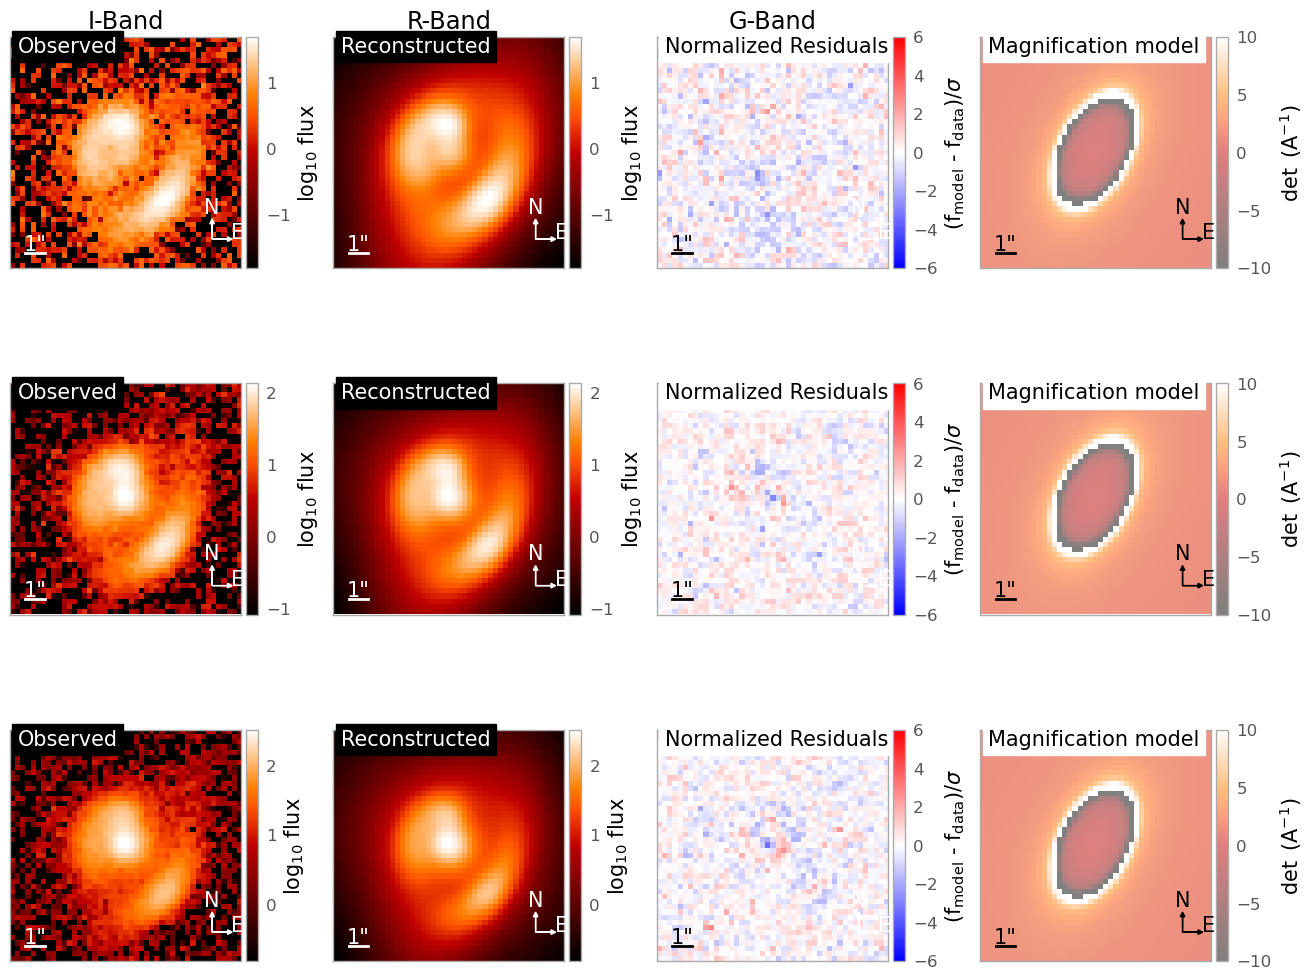

number of steps: 600
number of walkers: 150
number of parameters: 15
theta_E_lens0 2.2662 ± 0.0050
e1_lens0 -0.1571 ± 0.0035
e2_lens0 0.2151 ± 0.0037
R_sersic_source_light0 0.5786 ± 0.0136
n_sersic_source_light0 2.0531 ± 0.1122
e1_source_light0 -0.2753 ± 0.0079
e2_source_light0 0.3819 ± 0.0074
center_x_source_light0 0.3029 ± 0.0047
center_y_source_light0 -0.7388 ± 0.0053
R_sersic_lens_light0 0.9087 ± 0.0426
n_sersic_lens_light0 2.6770 ± 0.1728
e1_lens_light0 0.0226 ± 0.0102
e2_lens_light0 -0.0744 ± 0.0102
center_x_lens_light0 -0.0489 ± 0.0040
center_y_lens_light0 0.0912 ± 0.0039


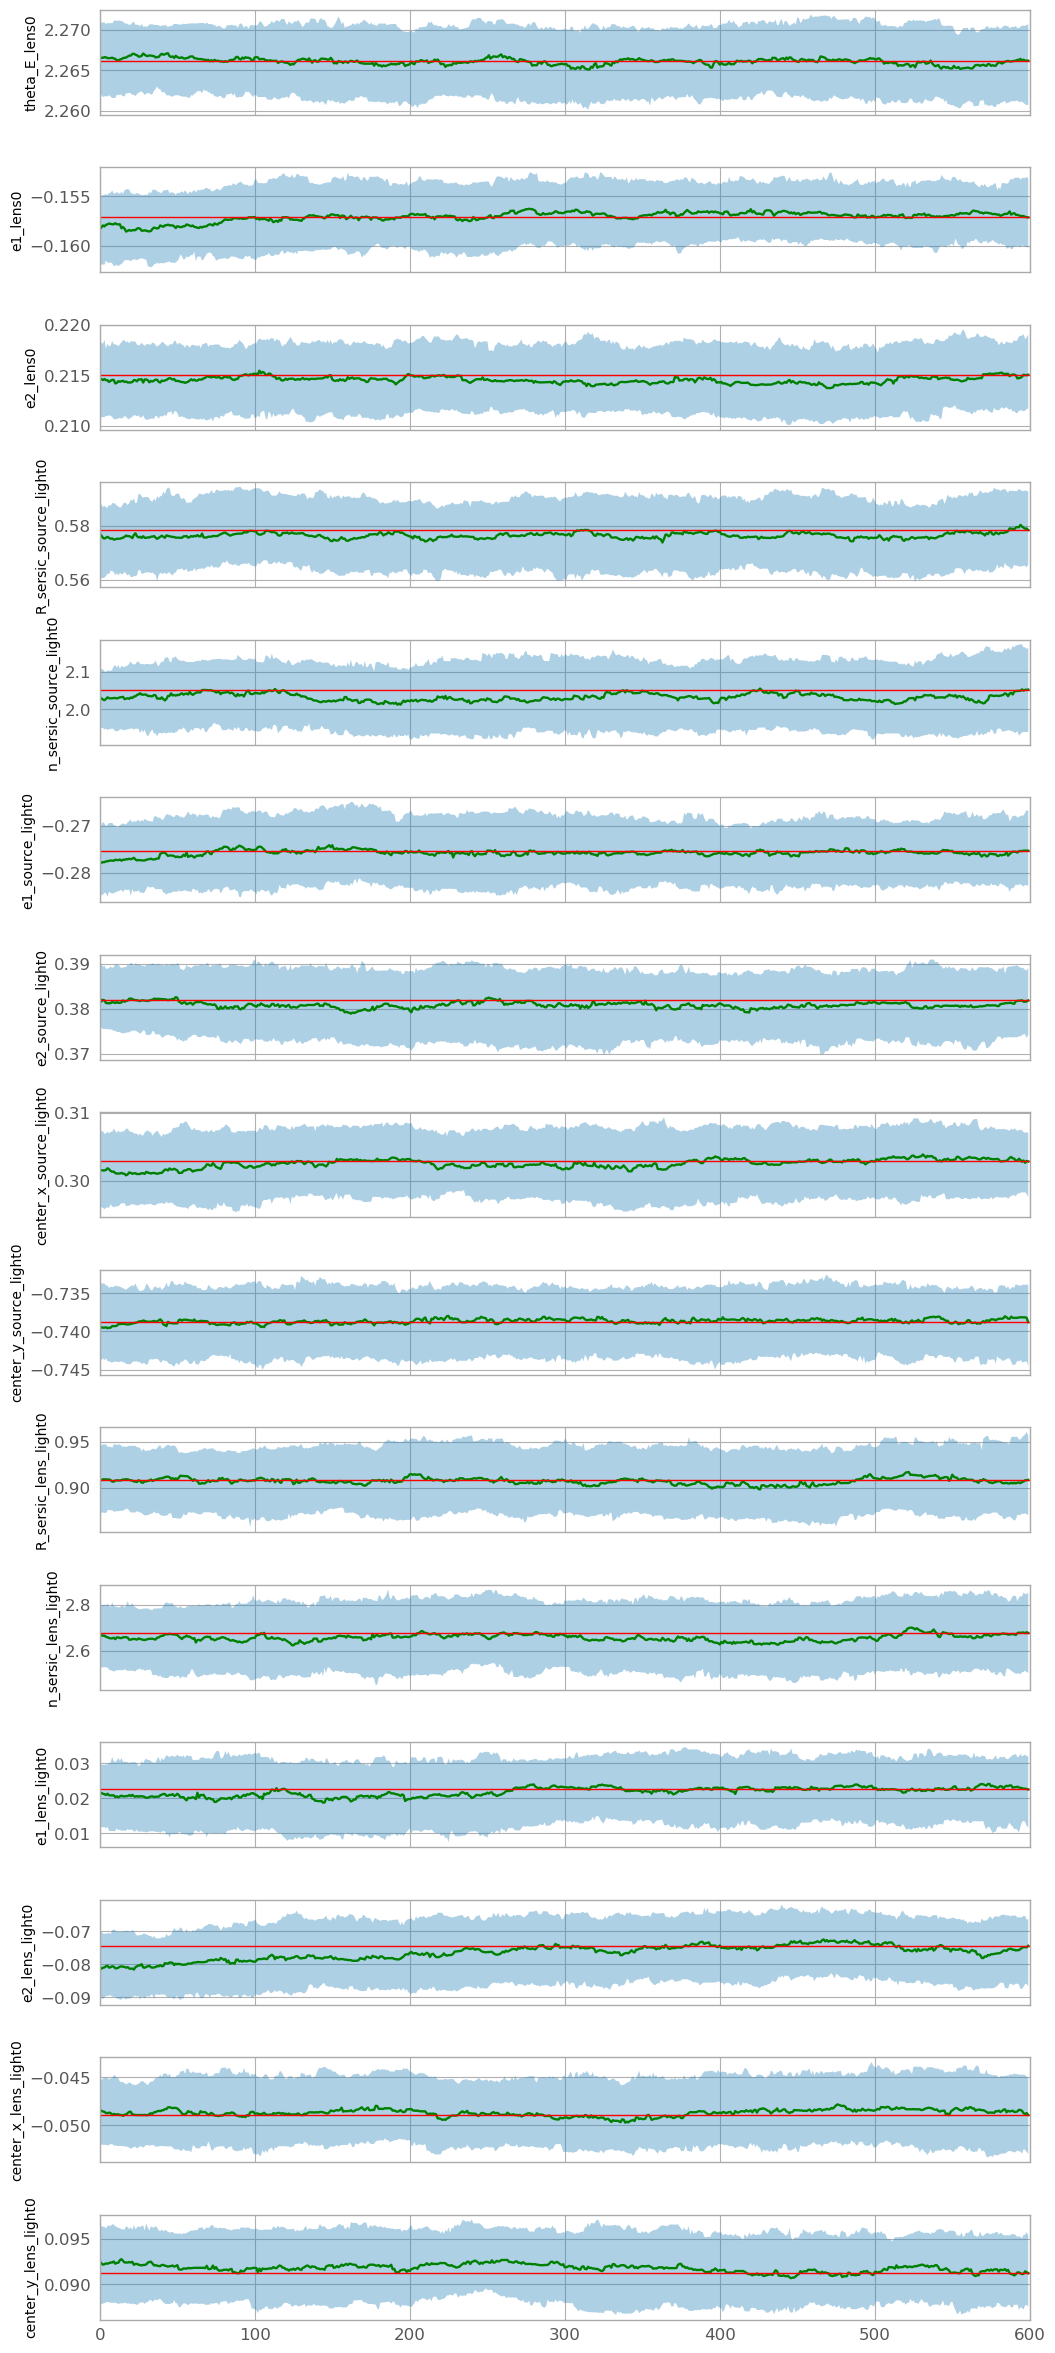

In [39]:
model(966802453)
plt.close('all')